In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces
import matplotlib.colors as mcolors
import seaborn as sns
import time
from itertools import product

###MDP solution approaches

In [2]:
class Sol_Env(gym.Env):
    def __init__(self):
        # Define ranges for each state variable
        self.player_sum_1_range = range(4, 31)  # Current sum 1
        self.dealer_sum_range = range(4, 29)  # Example range for dealer sum
        self.usable_ace_1 = [False, True]  # Usable ace for hand 1
        self.stick_happened = [False, True]  # end or not

        # Define actions
        self.actions = ['hit', 'stick']

    def get_all_states(self):
        """Generate all possible states."""
        states = list(product(
            self.player_sum_1_range,  # Current sum 1
            self.dealer_sum_range,  # Dealer's showing card
            self.usable_ace_1,  # Usable ace for player
            #self.usable_ace_2,  # Usable ace for dealer
            self.stick_happened  # end or not
        ))
        filtered_states = [
            state for state in states

            # Filter out states where player_sum < 12 and usable_ace = True
            if not (state[0] < 12 and state[2])
            and not (state[0] >= 21 and not state[3])
            and not (state[1] >= 21 and not state[3])
                           ]
        return filtered_states

    def get_possible_actions(self, state):
        """Return possible actions for a given state."""
        player_sum, dealer_sum, _, stick_happened = state
        if player_sum >= 21 or dealer_sum >= 21 or (dealer_sum >= 17 and stick_happened):
            return []
        elif stick_happened:
            return ['stick']
        elif dealer_sum >= 17 and not stick_happened:
            return ['hit']
        actions = ['hit', 'stick']
        return actions

    def get_reward(self, player_sum_1, dealer_sum, stick_happened):
        """
        Calculate the reward for a given state.
        """

        if player_sum_1 >= 21 or dealer_sum >= 21 or (dealer_sum >= 17 and stick_happened):
          if player_sum_1 > 21 and dealer_sum == 21 or dealer_sum == 21 and player_sum_1 < 21 or dealer_sum < 21 and player_sum_1 > 21:
                return -1
          elif player_sum_1 == 21 and dealer_sum > 21 or dealer_sum < 21 and player_sum_1 == 21 or dealer_sum > 21 and player_sum_1 < 21:
                return 1

          elif player_sum_1 == 21 and dealer_sum == 21 or dealer_sum > 21 and player_sum_1 > 21:
                return 0

          else:
            diff_21_player = 21 - player_sum_1
            diff_21_dealer = 21 - dealer_sum
            if diff_21_player > diff_21_dealer:
                return -1
            elif diff_21_player < diff_21_dealer:
                return 1
            else:
                return 0

        return 0


    def get_transition_probabilities(self, state, action):
        """
        Calculate transition probabilities for a given state-action pair.
        """
        distr = [1 / 13] * 8 + [4 / 13] + [1 / 13]  # Probabilities for cards 2–11
        card_values = list(range(2, 12))  # Cards are valued from 2 to 11
        distr_dict = {card_values[i]: distr[i] for i in range(len(card_values))}

        transitions = []
        player_sum_1, dealer_sum, ace_1, stick_happened = state

        if action == 'hit':
            if player_sum_1 >= 21:
                reward = self.get_reward(player_sum_1, dealer_sum, True)
                transitions.append((state, 1.0, reward))
            else:
                for card, prob in distr_dict.items():
                    new_sum = player_sum_1 + card
                    new_ace_1 = ace_1
                    if new_sum > 21 and new_ace_1:
                        if card == 11:
                          new_sum -= 10
                        else:
                          new_sum -= 10
                          new_ace_1 = False
                    if card == 11 and player_sum_1 < 11 and not new_ace_1:
                        new_ace_1 = True
                    if card == 11 and new_sum > 21 and not new_ace_1:
                        new_sum -= 10
                    if new_sum >= 21:
                        next_state = (new_sum, dealer_sum, new_ace_1, True)
                        reward = self.get_reward(new_sum, dealer_sum, True)
                        transitions.append((next_state, prob, reward))
                    else:
                        next_state = (new_sum, dealer_sum, new_ace_1, stick_happened)
                        reward = self.get_reward(new_sum, dealer_sum, stick_happened)
                        transitions.append((next_state, prob, reward))

        elif action == 'stick': # usable ace for the dealer?
            if dealer_sum >= 21:
                reward = self.get_reward(player_sum_1, dealer_sum, True)
                transitions.append((state, 1.0, reward))
            else:
                if not stick_happened:
                  if dealer_sum < 17:
                    for card, prob in distr_dict.items():
                        new_dealer_sum = dealer_sum + card
                        next_state = (player_sum_1, new_dealer_sum, ace_1, True)
                        reward = self.get_reward(player_sum_1, new_dealer_sum, True)
                        transitions.append((next_state, prob, reward))
                  else:
                    reward = self.get_reward(player_sum_1, dealer_sum, True)
                    transitions.append((state, 1.0, reward))
                else:
                  if dealer_sum < 17:
                    for card, prob in distr_dict.items():
                        new_dealer_sum = dealer_sum + card
                        next_state = (player_sum_1, new_dealer_sum, ace_1, stick_happened)
                        reward = self.get_reward(player_sum_1, new_dealer_sum, stick_happened)
                        transitions.append((next_state, prob, reward))
                  else:
                    reward = self.get_reward(player_sum_1, dealer_sum, stick_happened)
                    transitions.append((state, 1.0, reward))

        return transitions

In [3]:
bj = Sol_Env()
#len(bj.get_all_states())
#bj.get_all_states()[:500]

In [ ]:
all_states = bj.get_all_states()

for state in all_states[500:1000]:
    possible_actions = bj.get_possible_actions(state)
    for action in possible_actions:
        transitions = bj.get_transition_probabilities(state, action)
        for next_state, prob, reward in transitions:  # Assuming it's a list of (next_state, probability)
            print(f"State: {state}, Action: {action}, Next State: {next_state}, Probability: {prob}, Reward: {reward}")

In [4]:
print(f"Total states: {len(bj.get_all_states())}")
terminal_states = [s for s in bj.get_all_states() if not bj.get_possible_actions(s)]
print(f"Number of terminal states: {len(terminal_states)}")

Total states: 1592
Number of terminal states: 812


In [ ]:
for i in terminal_states:
  print(i)

Value iteration

In [5]:
def value_iteration_to_get_opt_solution(env, n=1000, theta=1e-15):
    """Compute the optimal value function V* using value iteration."""
    all_states = env.get_all_states()
    non_terminal_states = [s for s in all_states if not (s[0] >= 21 or s[1] >= 21 or (s[1] >= 17 and s[3]))]

    V_opt = {state: 0 for state in all_states}  # Initialize V*
    policy = {state: None for state in all_states}  # Store optimal policy

    for _ in range(n):
        delta = 0
        W = V_opt.copy()

        for state in non_terminal_states:
            old_value = V_opt[state]
            max_value = float('-inf')
            best_action = None

            for action in env.get_possible_actions(state):
                transitions = env.get_transition_probabilities(state, action)
                action_value = sum(prob * (reward + W[next_state]) for next_state, prob, reward in transitions)

                if action_value > max_value:
                    max_value = action_value
                    best_action = action

            V_opt[state] = max_value
            policy[state] = best_action
            delta = max(delta, abs(old_value - max_value))

        if delta < theta:
            break

    return V_opt, policy

In [6]:
V_opt, pol_opt = value_iteration_to_get_opt_solution(bj)

In [7]:
zero_value_states = [state for state, value in V_opt.items() if value == 0]
for i in zero_value_states:
  print(i)

(4, 17, False, True)
(4, 18, False, True)
(4, 19, False, True)
(4, 20, False, True)
(4, 21, False, True)
(4, 22, False, True)
(4, 23, False, True)
(4, 24, False, True)
(4, 25, False, True)
(4, 26, False, True)
(4, 27, False, True)
(4, 28, False, True)
(5, 17, False, True)
(5, 18, False, True)
(5, 19, False, True)
(5, 20, False, True)
(5, 21, False, True)
(5, 22, False, True)
(5, 23, False, True)
(5, 24, False, True)
(5, 25, False, True)
(5, 26, False, True)
(5, 27, False, True)
(5, 28, False, True)
(6, 17, False, True)
(6, 18, False, True)
(6, 19, False, True)
(6, 20, False, True)
(6, 21, False, True)
(6, 22, False, True)
(6, 23, False, True)
(6, 24, False, True)
(6, 25, False, True)
(6, 26, False, True)
(6, 27, False, True)
(6, 28, False, True)
(7, 17, False, True)
(7, 18, False, True)
(7, 19, False, True)
(7, 20, False, True)
(7, 21, False, True)
(7, 22, False, True)
(7, 23, False, True)
(7, 24, False, True)
(7, 25, False, True)
(7, 26, False, True)
(7, 27, False, True)
(7, 28, False

In [8]:
print(terminal_states == zero_value_states)

True


In [9]:
def value_iteration(env, theta=1e-15, gamma=1, n=1000):
    """Perform value iteration and track sup-norm error."""
    all_states = env.get_all_states()
    non_terminal_states = [s for s in all_states if not (s[0] >= 21 or s[1] >= 21 or (s[1] >= 17 and s[3]))]

    V = {state: 0 for state in all_states}  # Initialize V
    policy = {state: None for state in all_states}  # Initialize policy
    sup_norm_errors = []  # Track sup norm differences
    iterations = 0

    for _ in range(n):
        delta = 0
        W = V.copy()

        for state in non_terminal_states:
            old_value = V[state]
            max_value = float('-inf')
            best_action = None

            for action in env.get_possible_actions(state):
                transitions = env.get_transition_probabilities(state, action)
                action_value = sum(prob * (reward + W[next_state]) for next_state, prob, reward in transitions)

                if action_value > max_value:
                    max_value = action_value
                    best_action = action

            V[state] = max_value
            policy[state] = best_action
            delta = max(delta, abs(old_value - max_value))

        # Compute sup norm error
        sup_norm = max(abs(V[state] - V_opt[state]) for state in non_terminal_states)
        sup_norm_errors.append(sup_norm)
        iterations += 1
        if delta < theta:
            break

    return V, policy, iterations, sup_norm_errors

Value Iteration completed in 0.18 seconds and 17 iterations.


<ipython-input-10-1efa9489dc00>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


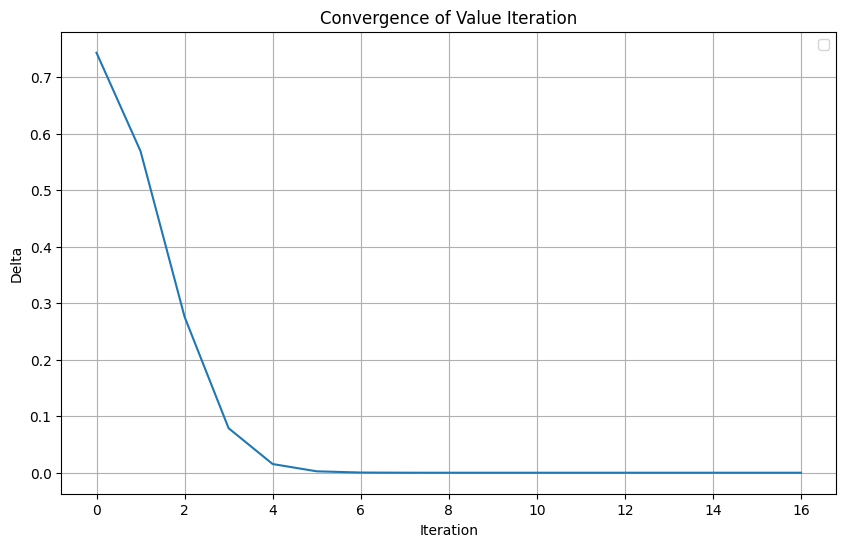

In [10]:
bj = Sol_Env()
start_time = time.time()
#V_vi, policy_vi, iterations_vi, deltas_vi = value_iteration(bj, V_opt)
V_vi, policy_vi, iterations_vi, deltas_vi = value_iteration(bj)
end_time = time.time()

print(f"Value Iteration completed in {end_time - start_time:.2f} seconds and {iterations_vi} iterations.")
# Plot convergence
def plot_convergence(deltas, label, name, step=1):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(deltas)), deltas)
    #plt.plot(range(1, len(deltas)+1), deltas)
    plt.xlabel('Iteration')
    plt.ylabel('Delta')
    plt.title(label)
    plt.xticks(range(0, len(deltas), step))
    plt.legend()
    plt.grid()
    plt.savefig(name, format="jpg", dpi=300)
    plt.show()
plot_convergence(deltas_vi, 'Convergence of Value Iteration', "value_iteration.jpg", 2)

In [11]:
print(V_opt == V_vi)
print(pol_opt == policy_vi)

True
True


Gauss-Seidel

In [12]:
def gauss_seidel(env, V_opt, n = 100, theta=1e-15):
    """Perform value iteration to find the optimal policy."""
    # Get all states and filter out terminal ones
    all_states = env.get_all_states()
    non_terminal_states = [state for state in all_states if not(state[0] >= 21 or state[1] >= 21 or (state[1] >= 17 and state[3]))]
    #non_terminal_states = [state for state in all_states if not(state[0] >= 21 or state[1] >= 21 or state[1] > 17 and state[4])]

    V = {state: 0 for state in all_states}  # Initialize value function
    policy = {state: None for state in all_states}  # Initialize policy

    iterations = 0
    delta_list = []  # To track convergence

    for i in range(n):
    #while iterations != n:
        for state in non_terminal_states:
            old_value = V[state]
            max_value = float('-inf')
            best_action = None
            #print(state)
            for action in env.get_possible_actions(state):
                #print(action)
                transitions = env.get_transition_probabilities(state, action)
                #for i in transitions:
                  #print(i)
                action_value = sum(
                    prob * (reward + V[next_state])
                    for next_state, prob, reward in transitions
                )
                if action_value > max_value:
                    max_value = action_value
                    best_action = action

            V[state] = max_value
            policy[state] = best_action

        diff = max(abs(V_opt[key] - V[key]) for key in V)
        delta_list.append(diff)
        iterations += 1
        #if diff == 0:
        if diff < theta:
            break

    return V, policy, iterations, delta_list

Gauss-Seidel completed in 0.14 seconds and 15 iterations.


<ipython-input-10-1efa9489dc00>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


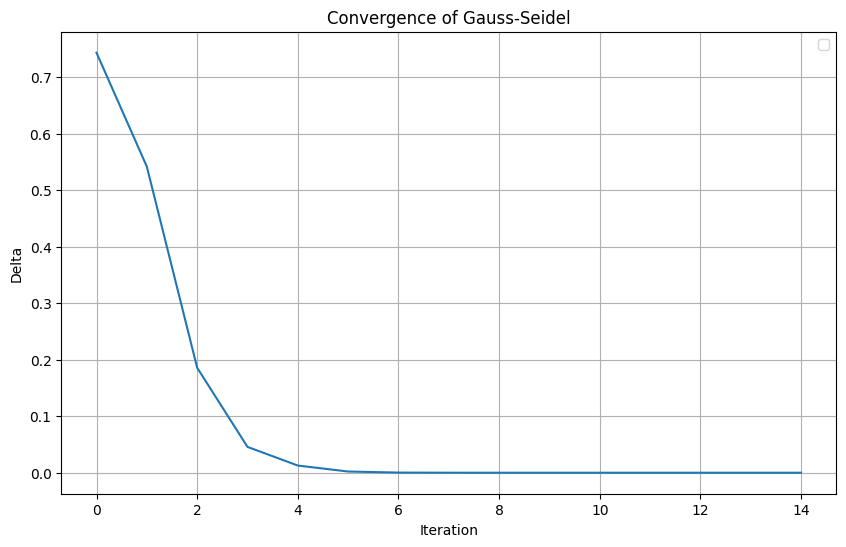

In [13]:
# Main Execution
bj = Sol_Env()

start_time = time.time()
V_gs, policy_gs, iterations_gs, deltas_gs = gauss_seidel(bj, V_opt)
end_time = time.time()

print(f"Gauss-Seidel completed in {end_time - start_time:.2f} seconds and {iterations_gs} iterations.")
#print(deltas)
plot_convergence(deltas_gs, 'Convergence of Gauss-Seidel', "gauss-seidel.jpg", 2)

In [14]:
print(V_opt == V_gs)
print(pol_opt == policy_gs)

True
True


Optimistic Policy iteration

In [15]:
def opt_policy_iteration(env, n=100, theta=1e-15):
    """Perform policy iteration and track sup-norm error."""
    all_states = env.get_all_states()
    non_terminal_states = [s for s in all_states if not (s[0] >= 21 or s[1] >= 21 or (s[1] > 17 and s[3]))]

    V = {state: 0 for state in all_states}  # Initialize V
    # Initialize policy and value function
    policy = {}
    for state in all_states:
        possible_actions = env.get_possible_actions(state)
        if possible_actions:  # Ensure there are valid actions
            policy[state] = possible_actions[0]  # Default to the first action
        else:
            policy[state] = None  # No action for terminal states
    sup_norm_errors = []  # Track sup norm differences
    iterations = 0
    iterations2 = 0
    for _ in range(n):
        # Policy Evaluation
        while True:
            delta = 0
            for state in non_terminal_states:
                old_value = V[state]
                action = policy[state]
                if action is None:
                    continue
                transitions = env.get_transition_probabilities(state, action)
                if not transitions:
                    continue
                V[state] = sum(prob * (reward + V[next_state]) for next_state, prob, reward in transitions)
                delta = max(delta, abs(old_value - V[state]))
            iterations2 += 1
            if delta < theta:
                break

        # Policy Improvement
        policy_stable = True
        for state in non_terminal_states:
            old_action = policy[state]
            best_action = None
            max_value = float('-inf')

            for action in env.get_possible_actions(state):
                transitions = env.get_transition_probabilities(state, action)
                action_value = sum(prob * (reward + V[next_state]) for next_state, prob, reward in transitions)

                if action_value > max_value:
                    max_value = action_value
                    best_action = action

            if best_action is not None:
                policy[state] = best_action
                if old_action != best_action:
                    policy_stable = False

        # Compute sup norm error
        sup_norm = max(abs(V[state] - V_opt[state]) for state in non_terminal_states)
        sup_norm_errors.append(sup_norm)
        iterations += 1
        if policy_stable:
            break

    return V, policy, iterations, iterations2, sup_norm_errors

Optimistic Policy Iteration completed in 0.24 seconds and 3 iterations.


<ipython-input-10-1efa9489dc00>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


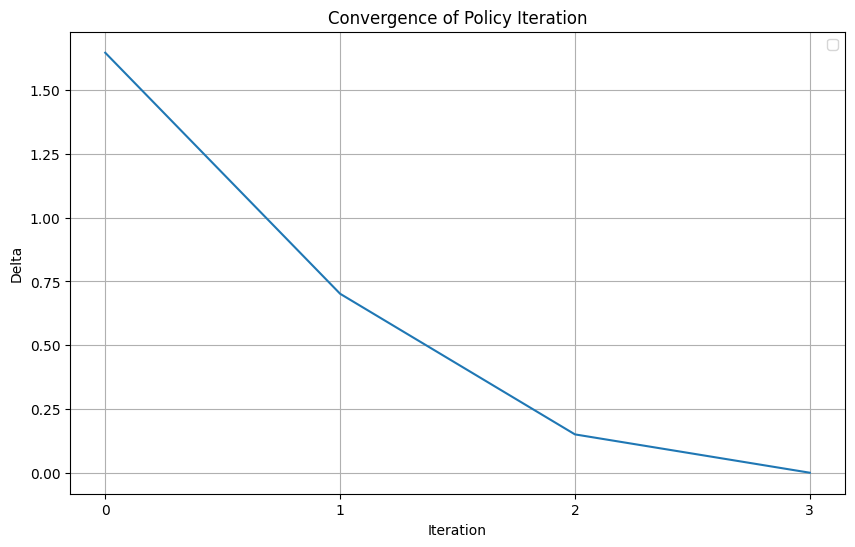

33


In [16]:
bj = Sol_Env()

start_time = time.time()
#V_pi, policy_pi, iterations_pi, deltas_pi, deltas_pi2 = opt_policy_iteration(bj, V_opt)
V_pi, policy_pi, iterations_pi, iterations_pi2, deltas_pi = opt_policy_iteration(bj)
end_time = time.time()


# Trim the list until the first 0 element
trimmed_deltas = deltas_pi[:next((i for i, x in enumerate(deltas_pi) if x == 0), len(deltas_pi))]
print(f"Optimistic Policy Iteration completed in {end_time - start_time:.2f} seconds and {len(trimmed_deltas)} iterations.")
plot_convergence(deltas_pi, 'Convergence of Policy Iteration', 's.jpg')
#plot_convergence(trimmed_deltas, 'Convergence of Policy Iteration', 's.jpg')
print(iterations_pi2)

In [ ]:
print(deltas_pi)
#print(policy_pi)

In [17]:
print(V_opt == V_pi)
print(pol_opt == policy_pi)

True
True
